In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import segnet
from src.utils import history_to_results
from src.utils import heatmap

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models
weights_file = 'models/BayesianSegNet-CamVid11.h5'

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Building',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Building',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Car',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Building',
 'TrafficLight': 'Building',
 'Train': 'Car',
 'Tree': 'Tree',
 'Truck_Bus': 'Car',
 'Tunnel': 'Building',
 'VegetationMisc': 'Tree',
 'Void': 'Road',
 'Wall': 'Building'}

In [4]:
batch_size = 8
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to
crop_size = (352, 480)

In [5]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in crop_size:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Training

In [6]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=crop_size, batch_size=batch_size)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


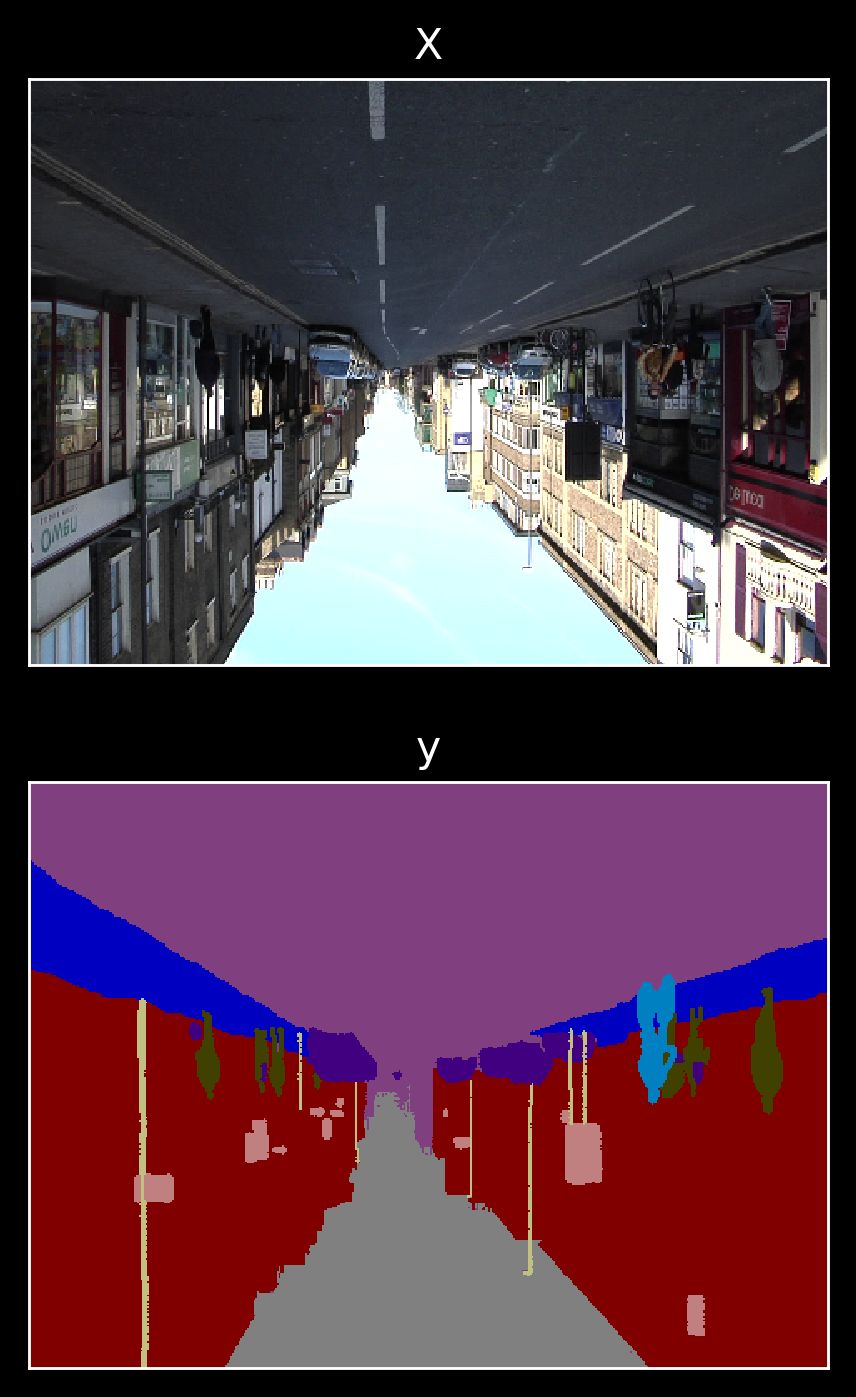

In [7]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [8]:
# build the model for the image shape and number of labels
model = segnet.build_segnet((*crop_size, 3), camvid11.n, 
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_weights,
    dropout_rate=0.5,
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SegNet_input (InputLayer)    (None, 352, 480, 3)       0         
_________________________________________________________________
pixel_norm (Lambda)          (None, 352, 480, 3)       0         
_________________________________________________________________
lcn (ContrastNormalization)  (None, 352, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 352, 480, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 352, 480, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 352, 480, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 352, 480, 64)      36928     
__________

In [9]:
# create the callbacks for the training procedure
callbacks = [
    PlotLossesKeras(),
    EarlyStopping(monitor='loss', patience=10),
    ModelCheckpoint(weights_file, 
        monitor='loss', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='min'
    ),
    LearningRateScheduler(lambda _, lr: 0.95 * lr),
]

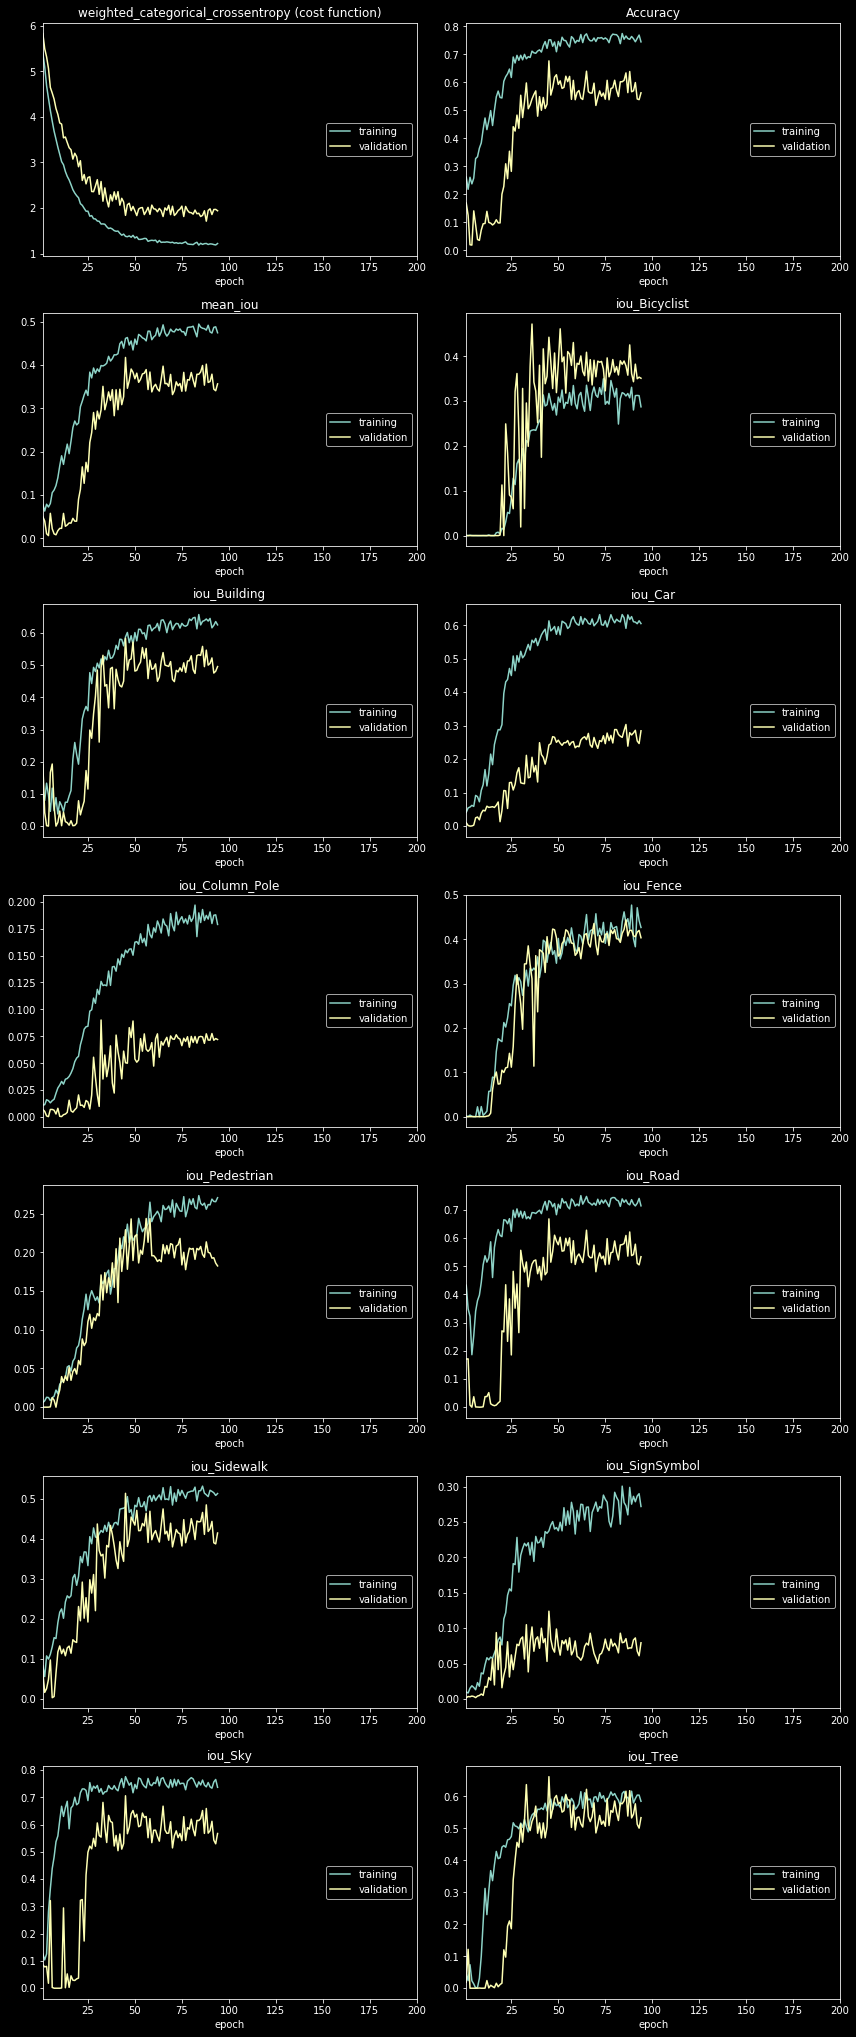

In [10]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / batch_size),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0
)

In [11]:
history_to_results(history)

train       val
acc          0.744758  0.562849
Bicyclist    0.287397  0.351168
Building     0.625051  0.495541
Car          0.604941  0.284768
Column_Pole  0.178929  0.072047
Fence        0.427134  0.403948
Pedestrian   0.270795  0.182611
Road         0.714667  0.534148
Sidewalk     0.513728  0.415088
SignSymbol   0.271961  0.079443
Sky          0.736483  0.567093
Tree         0.584282  0.533195
loss         1.219034  1.938222
mean_iou     0.474124  0.356277

## Load Best Model

In [12]:
model.load_weights(weights_file)

# Test Metrics

In [13]:
# wrap the SegNet with a MonteCarlo estimator of mean and variance
bayesian_model = segnet.wrap_uncertainty(model)
bayesian_model.summary()

/users/PMIU0138/miu0212/the-100-layers-tiramisu/src/segnet.py:236: UserWarning: Output "var" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "var" during training.
  metrics={'mc': model.metrics}


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
SegNet_input (InputLayer)       (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
monte_carlo_1 (MonteCarlo)      (None, 352, 480, 11, 0           SegNet_input[0][0]               
__________________________________________________________________________________________________
var_1 (Var)                     (None, 352, 480, 11) 0           monte_carlo_1[0][0]              
__________________________________________________________________________________________________
mc (Mean)                       (None, 352, 480, 11) 0           monte_carlo_1[0][0]              
__________________________________________________________________________________________________
var (Mean)

In [14]:
metrics = bayesian_model.evaluate_generator(generators['test'], steps=233)
names = bayesian_model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

val
loss                0.413139
mc_loss             0.413139
mc_acc              0.806015
mc_mean_iou         0.416095
mc_iou_Bicyclist    0.119079
mc_iou_Building     0.572465
mc_iou_Car          0.417536
mc_iou_Column_Pole  0.166672
mc_iou_Fence        0.133422
mc_iou_Pedestrian   0.200066
mc_iou_Road         0.794985
mc_iou_Sidewalk     0.666265
mc_iou_SignSymbol   0.115912
mc_iou_Sky          0.856174
mc_iou_Tree         0.534474

# Qualitative Results

In [15]:
def predict(generator):
    X, y = next(generator)
    p, s = bayesian_model.predict(X)
    return X, camvid11.unmap(y), camvid11.unmap(p), heatmap(s, 'Greys')

### Train Results

In [16]:
X, y, p, s = predict(generators['train'])

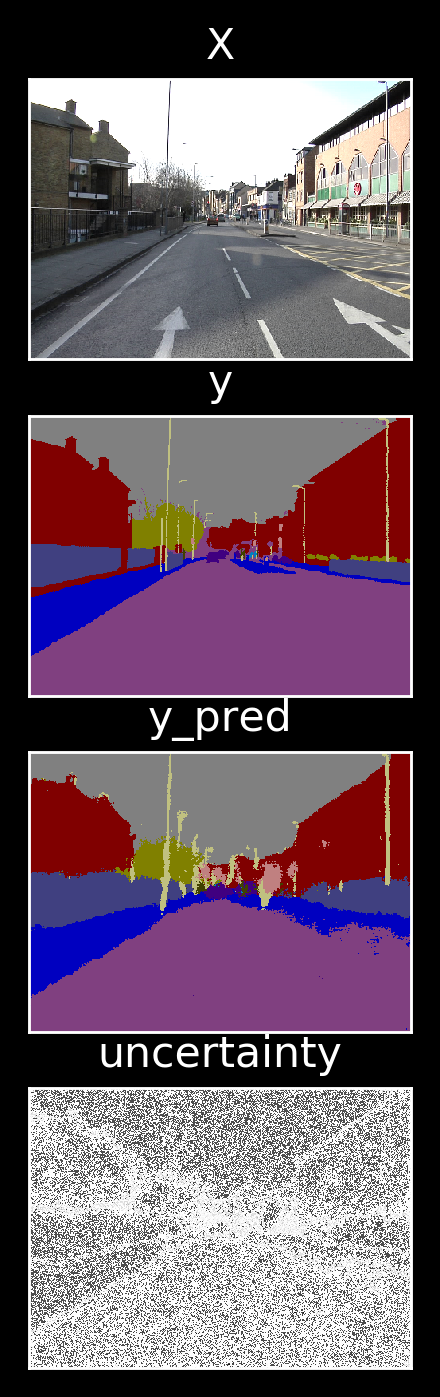

In [17]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

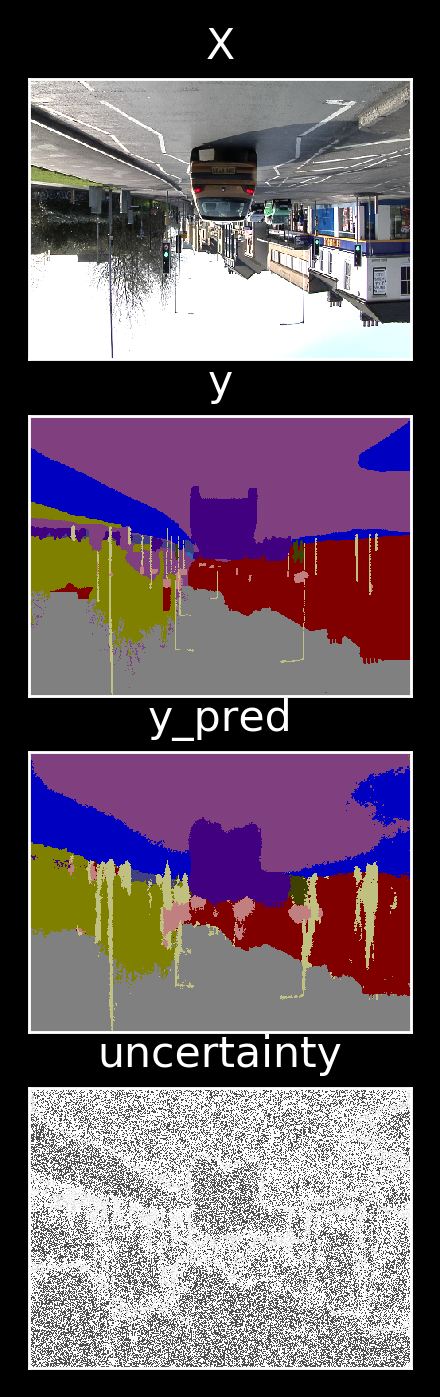

In [18]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1], uncertainty=s[1])

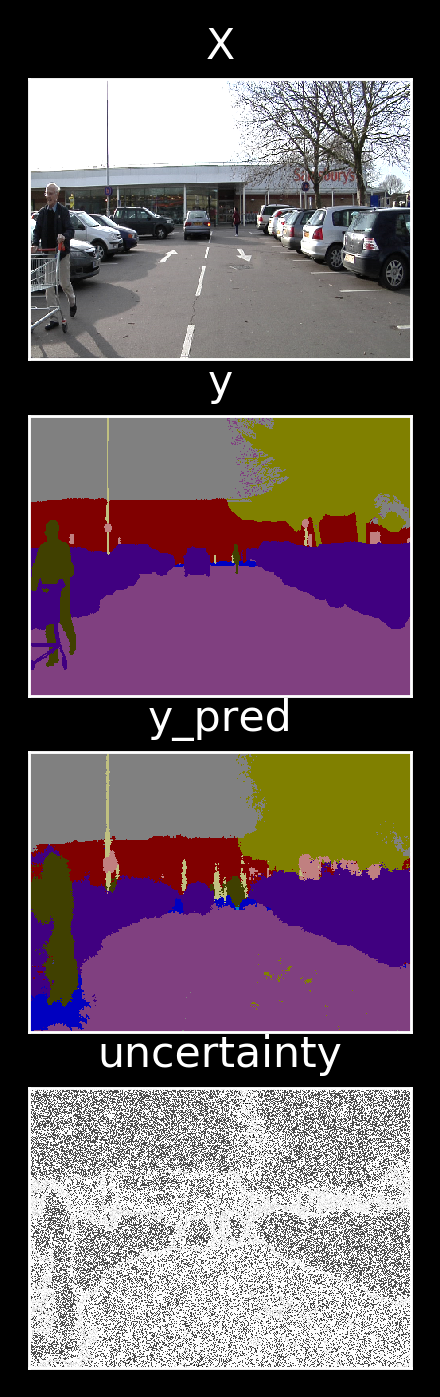

In [19]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2], uncertainty=s[2])

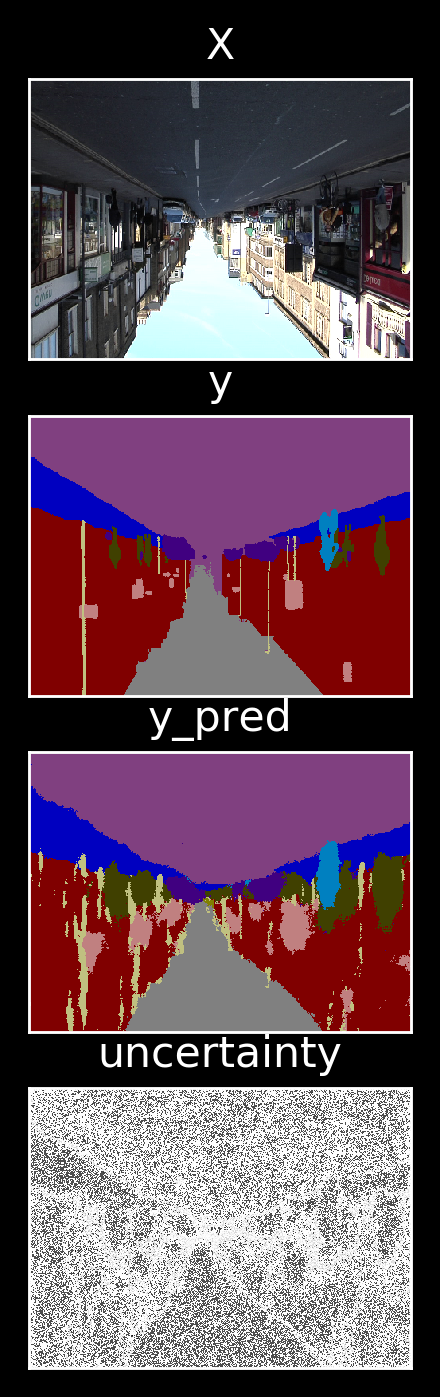

In [20]:
camvid.plot(X=X[3], y=y[3], y_pred=p[3], uncertainty=s[3])

### Validation Results

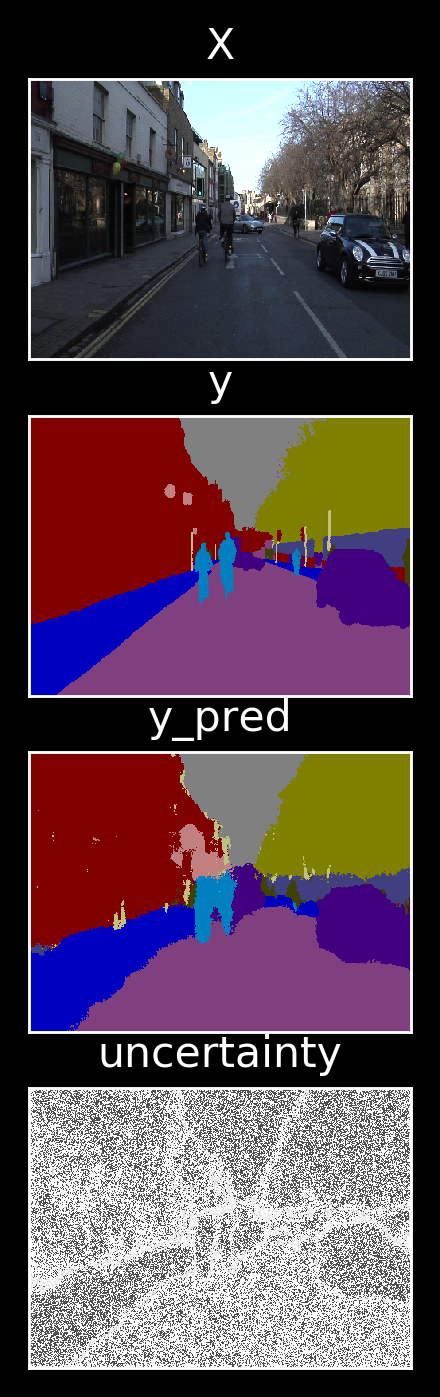

In [21]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

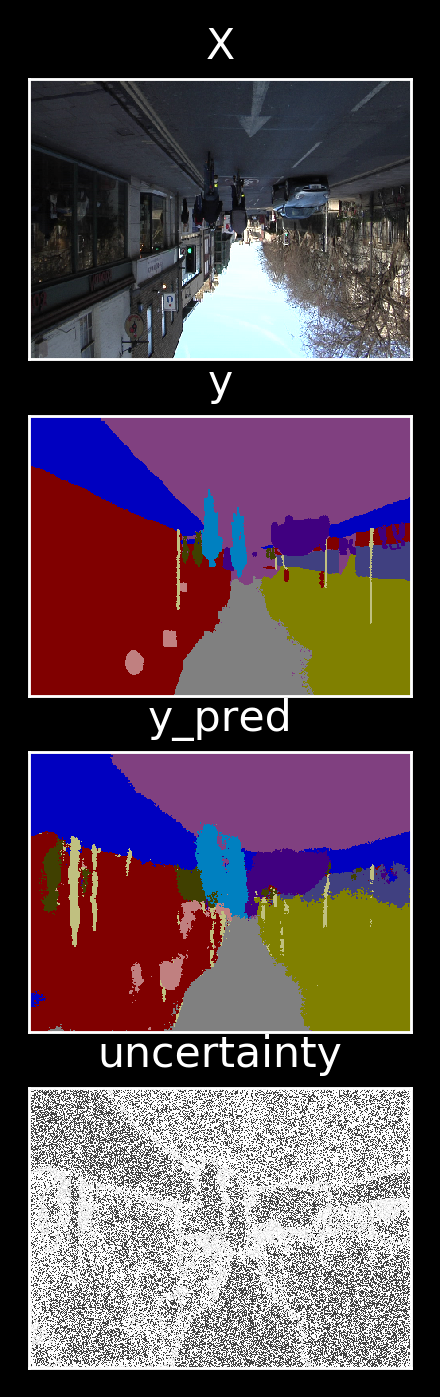

In [22]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

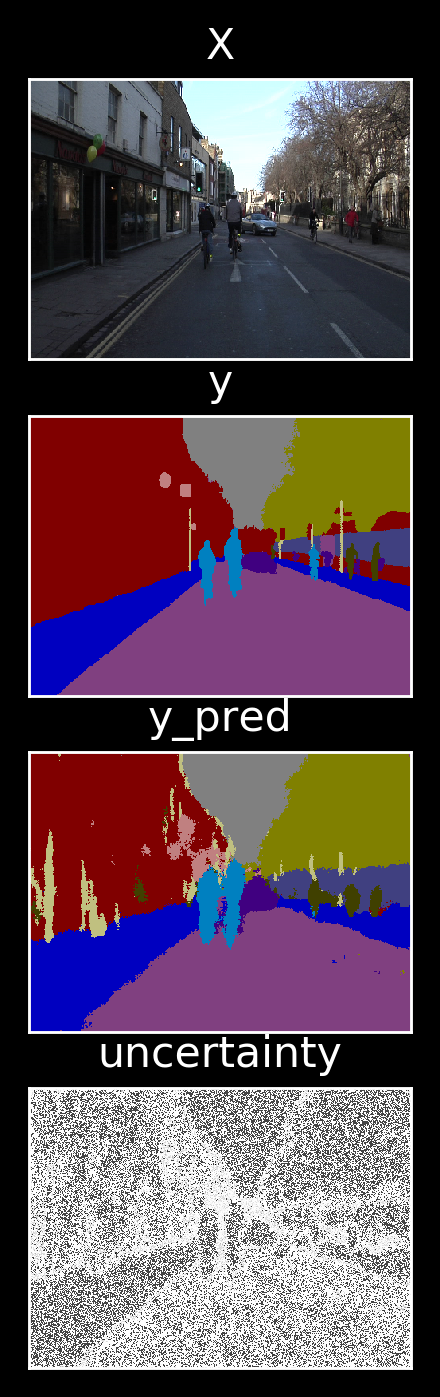

In [23]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

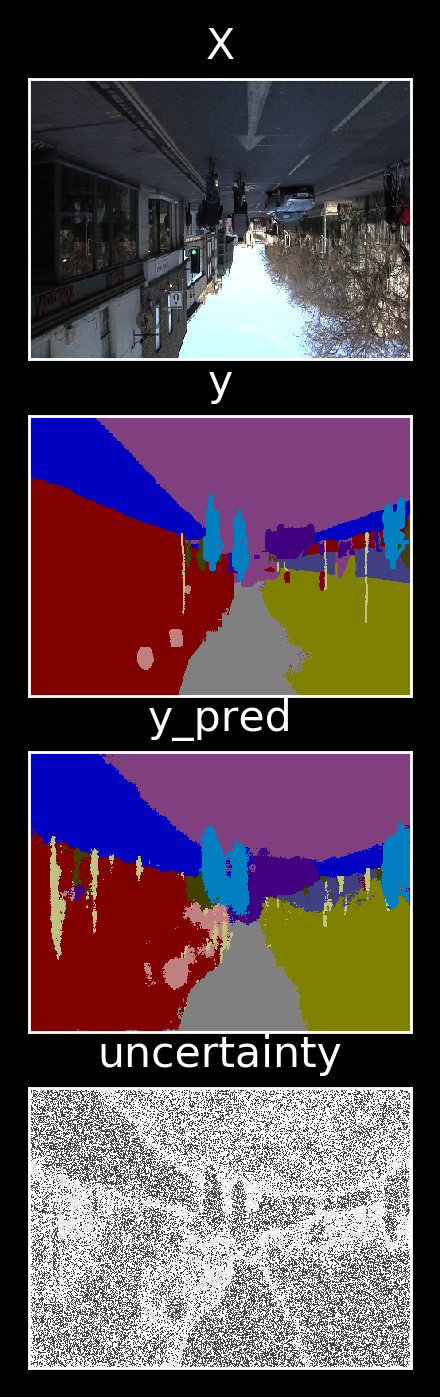

In [24]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

### Test Results

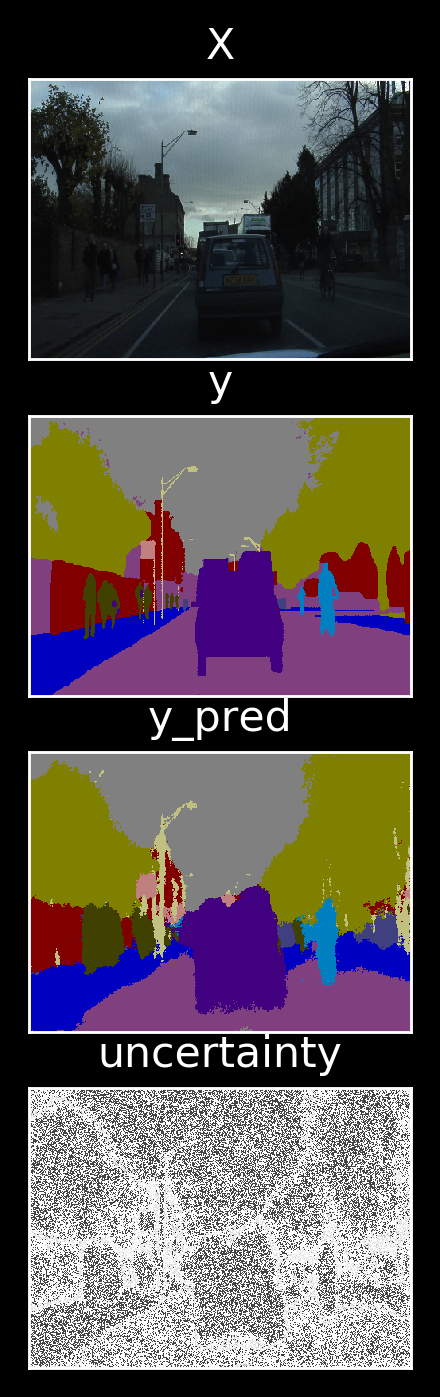

In [25]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

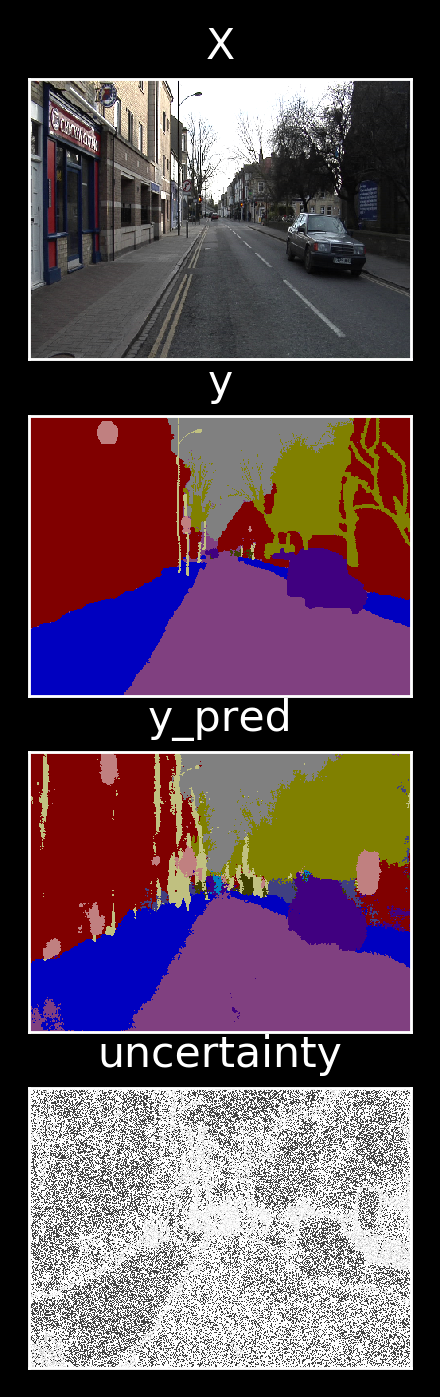

In [26]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

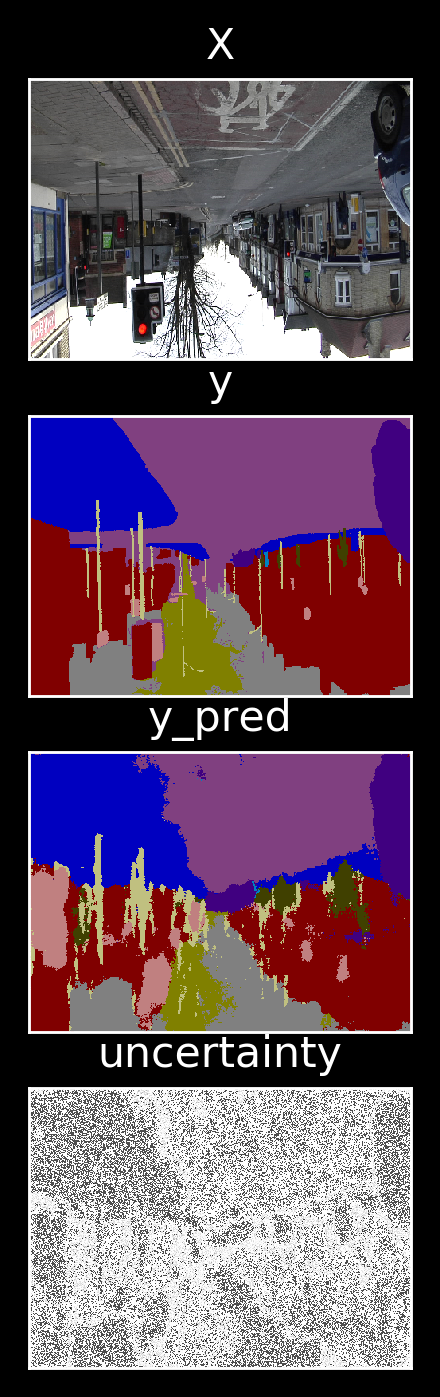

In [27]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

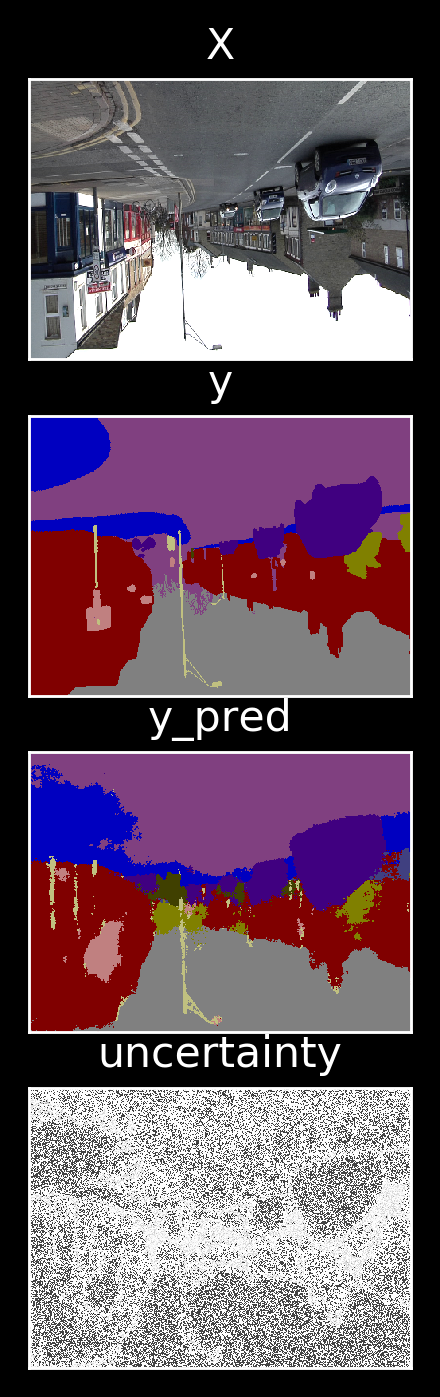

In [28]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])